In [2]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os, csv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Download the data from ./data/train_tweets/

In [3]:
data_path = "./data/train_tweets/"
files = os.listdir(data_path)

data = {
    file.split(".")[0]:
    pd.read_csv(
        data_path + file,
        sep=",",
        header=0,  # First row is the header
        quotechar='"',  # Character enclosing the strings
        engine="python"  # Ensure compatibility with complex parsing
    )
    for file in files
    if file.endswith(".csv")
}

print(list(data.values())[0].head())



    ID  MatchID  PeriodID  EventType      Timestamp  \
0  2_0        2         0          0  1403538600000   
1  2_0        2         0          0  1403538600000   
2  2_0        2         0          0  1403538600000   
3  2_0        2         0          0  1403538600000   
4  2_0        2         0          0  1403538600000   

                                               Tweet  
0  RT @soccerdotcom: If #ESP beats #AUS we'll giv...  
1  Visit the #SITEP official web site here http:/...  
2  RT @soccerdotcom: If #ESP beats #AUS we'll giv...  
3  RT @worldsoccershop: If there is a winner in t...  
4  RT @soccerdotcom: If #AUS beats #ESP we'll giv...  


In [4]:
train_files = list(data.keys())[:-1]
test_files = [list(data.keys())[-1]]
print(train_files, test_files)

# x train fields: ID, MatchID, PeriodID, Timestamp
# y train fields: EventType
train = {
    file: data[file][["ID", "MatchID", "PeriodID", "Timestamp", "Tweet", "EventType"]]
    for file in train_files
}

test = {
    file: data[file][["ID", "MatchID", "PeriodID", "Timestamp", "Tweet", "EventType"]]
    for file in test_files
}


['AustraliaSpain34', 'PortugalGhana58', 'CameroonBrazil36', 'GermanyBrazil74', 'BelgiumSouthKorea59', 'NetherlandsChile35', 'GermanyAlgeria67', 'FranceGermany70', 'MexicoCroatia37', 'FranceNigeria66', 'AustraliaNetherlands29', 'HondurasSwitzerland54', 'ArgentinaGermanyFinal77', 'ArgentinaBelgium72', 'USASlovenia2010'] ['GermanyUSA57']


CNN in parrallel: https://iopscience.iop.org/article/10.1088/1742-6596/1792/1/012074/pdf

In [24]:
from torch.utils.data import TensorDataset, DataLoader

# Définir le modèle TCN
class TCN(nn.Module):
    def __init__(self, timestep, kernel_size:float, kernel_ev, num_layers, out_layers, num_feature=2):
        # padding = (kernel_size - 1) // 2 pour conserver la même longueur.
        # new_channels_size = timesteps - kernel_size + 1
        super(TCN, self).__init__()

        self.layers = nn.ModuleList()
        channel_size = timestep
        for index_layer in range(num_layers):
            if index_layer == 0:
                in_channels = num_feature
                out_channels = 32
                kernel_value = max(int(kernel_size * timestep), 1)
                padding = (kernel_value - 1) // 2
            else:
                in_channels = self.layers[-1].out_channels
                out_channels = in_channels
                kernel_value = self.layers[-1].kernel_size[0]
            
            if out_layers == "keep_length": pass
            elif out_layers == "increase": out_channels = min(2 * out_channels, 256)
            elif out_layers == "decrease": out_channels //= 1.2
            out_channels = max(int(out_channels), 1)

            if kernel_ev == "keep_same": kernel_size = kernel_value if kernel_size < channel_size else channel_size
            elif kernel_ev == "increase": kernel_value += kernel_size < channel_size
            elif kernel_ev == "decrease": kernel_value -= kernel_size > 1

            if kernel_value > channel_size:
                kernel_value = channel_size
            padding = int((kernel_value - 1) // 2)

            self.layers.append(
                nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_value, 
                    padding=padding
                )
            )
            channel_size = int(channel_size - kernel_value + 1 + 2 * padding)

        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(self.layers[-1].out_channels * channel_size, 2)

        # self.conv1 = nn.Conv1d(in_channels=num_feature, out_channels=64, kernel_size=kernel_size, padding=padding)
        # self.relu = nn.ReLU()
        # self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=kernel_size)
        # 
        # self.fc = nn.Linear(128 * (timestep - kernel_size + 1), 2)
        
    def forward(self, x):
        # x doit être de forme [batch_size, num_features, timesteps]
        x = x.permute(0, 2, 1) # brefore [batch_size, timesteps, num_features]
        for layer in self.layers:
            x = layer(x)
            x = torch.relu(x)
        
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [6]:
def preprocess_data(train, test, timesteps):
    """
    Prétraiter les données pour l'entraînement et le test.
    Les données sont normalisées et transformées en tenseurs PyTorch.
    train: dict, données d'entraînement
    test: dict, données de test
    timesteps: int, nombre de pas de temps

    return: tuple(dict[train_file_name, DataLoader], TestDataLoader)
    """
    datasets = {}

    for key in train.keys():
        dataset = train[key].copy()
        dataset.loc[:, 'Tweet_Length'] = dataset['Tweet'].str.len()
        agg_data = dataset.groupby('PeriodID').agg(
            Avg_Tweet_Length=('Tweet_Length', 'mean'),   # Longueur moyenne des tweets
            Tweet_Count=('Tweet', 'count'),             # Nombre de tweets
            EventType=('EventType', 'first')            # Type d'évènement
        ).reset_index()

        # Normaliser les données
        agg_data['Tweet_Count'] = (agg_data['Tweet_Count'] - agg_data['Tweet_Count'].mean()) / agg_data['Tweet_Count'].std()
        agg_data['Avg_Tweet_Length'] = (agg_data['Avg_Tweet_Length'] - agg_data['Avg_Tweet_Length'].mean()) / agg_data['Avg_Tweet_Length'].std()

        # Trier les données par PeriodID
        agg_data = agg_data.sort_values('PeriodID').reset_index(drop=True)

        X = agg_data[['Tweet_Count', 'Avg_Tweet_Length']].values
        y = agg_data['EventType'].values

        X_seq = []
        y_seq = []
        for i in range(len(X) - timesteps):
            X_seq.append(X[i:i+timesteps])
            y_seq.append(y[i+timesteps])

        X_seq = np.array(X_seq)  # Shape: (num_samples, timesteps, num_features)
        y_seq = np.array(y_seq)

        # Convertir en tenseurs PyTorch
        X_seq = torch.from_numpy(X_seq).float()
        y_seq = torch.from_numpy(y_seq).long()

        train_dataset = TensorDataset(X_seq, y_seq)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # sequences indépendantes
        datasets[key] = train_loader

    # Créer test_loader
    test_dataset = test[list(test.keys())[0]].copy()
    test_dataset.loc[:, 'Tweet_Length'] = test_dataset['Tweet'].str.len()
    agg_data = test_dataset.groupby('PeriodID').agg(
        Avg_Tweet_Length=('Tweet_Length', 'mean'),   # Longueur moyenne des tweets
        Tweet_Count=('Tweet', 'count'),             # Nombre de tweets
        EventType=('EventType', 'first')            # Type d'évènement
    ).reset_index()

    # Normaliser les données
    agg_data['Tweet_Count'] = (agg_data['Tweet_Count'] - agg_data['Tweet_Count'].mean()) / agg_data['Tweet_Count'].std()
    agg_data['Avg_Tweet_Length'] = (agg_data['Avg_Tweet_Length'] - agg_data['Avg_Tweet_Length'].mean()) / agg_data['Avg_Tweet_Length'].std()

    # Trier les données par PeriodID
    agg_data = agg_data.sort_values('PeriodID').reset_index(drop=True)

    X = agg_data[['Tweet_Count', 'Avg_Tweet_Length']].values
    y = agg_data['EventType'].values

    X_seq = []
    y_seq = []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])

    X_seq = np.array(X_seq)  # Shape: (num_samples, timesteps, num_features)
    y_seq = np.array(y_seq)

    # Convertir en tenseurs PyTorch
    X_seq = torch.from_numpy(X_seq).float()
    y_seq = torch.from_numpy(y_seq).long()

    test_dataset_tensor = TensorDataset(X_seq, y_seq)
    test_loader = DataLoader(test_dataset_tensor, batch_size=64, shuffle=False)

    return datasets, test_loader

In [7]:
def plot_model(): ...

In [25]:
# hyperparamètres à tester: timesteps, kernel_size, padding, kernel_size_through_layers, num_layers, out layers
timesteps = [3, 4, 5, 8, 16, 32]
kernel_size_in_percent_of_timesteps = [0.2, 0.5, 0.7] # cast to int
kernel_size_through_layers = ["keep_same", "increase", "decrease"]
num_layers = [2, 3, 4]
out_layers = ["keep_length", "decrease", "increase"]

# Générer toutes les combinaisons de paramètres
params_combinations = [
    (k, ktl, nl, ol)
    for k in kernel_size_in_percent_of_timesteps
    for ktl in kernel_size_through_layers
    for nl in num_layers
    for ol in out_layers
]

print(f"Number of combinations of hyperparameters: {len(params_combinations) * len(timesteps)}")
# sortir les timesteps pour optimiser le temps de calcul (limiter le nombre d'appel à preprocess_data)


"""[{timestep: int, kernel_size: int, padding: str, kernel_size_through_layers: str, num_layers: int, out_layers: str, accuracy_train: [float], loss_train: [], accuracy_test: float}]"""
input_size = 2
criterion = nn.CrossEntropyLoss()


def test_model(timestep, params_combinations, train, test):
    results: list[dict] = []
    index = 0

    X_train, test_loader = preprocess_data(train, test, timestep)
    for kernel, kernel_layers, num_layers, out_layers in params_combinations:
        index += 1
        print(f"[Training] [{timestep} step] [{index}/{len(params_combinations)}]")
        try:
            model = TCN(timestep=timestep, kernel_size=kernel, kernel_ev=kernel_layers, num_layers=num_layers, out_layers=out_layers)
        except Exception as e:
            print(f"Error while creating model with timestep: \n{timestep}, kernel_size: {kernel}, \nkernel_size_through_layers: {kernel_layers}, num_layers: {num_layers}, out_layers: {out_layers}")
            raise e
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        model.to(device)
        model.train()
        current_results = {
            "timestep": timestep,
            "kernel_size": kernel,
            "kernel_size_through_layers": kernel_layers,
            "num_layers": num_layers,
            "out_layers": out_layers,
            "accuracy_train": [],
            "loss_train": [],
            "accuracy_test": 0
        }

        for epoch in range(1, 75):
            for key in X_train:
                train_loader = X_train[key]
                for i, (X_batch, y_batch) in enumerate(train_loader):
                    # Forward pass
                    optimizer.zero_grad()
                    try:
                        outputs = model(X_batch)
                    except Exception as e:
                        print(f"Error while training model with timestep: \n{timestep}, kernel_size: {kernel}, \nkernel_size_through_layers: {kernel_layers}, num_layers: {num_layers}, out_layers: {out_layers}")
                        raise e
                    
                    loss = criterion(outputs, y_batch)

                    if len(current_results["loss_train"]) < epoch:
                        current_results["loss_train"].append(loss.item())
                        current_results["accuracy_train"].append((outputs.argmax(1) == y_batch).float().mean().item())
                    loss.backward()
                    optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = 100 * correct / total
        current_results["accuracy_test"] = accuracy
        results.append(current_results)

        print(f"[Test] Accuracy: {accuracy}")
    
    print(f"Finished training for timestep: {timestep}")
    return results

results: list[dict] = []
    
for timestep in timesteps:
    results.extend(test_model(timestep, params_combinations, train, test))
        
# Sauvegarder les résultats
with open("results.csv", "w") as f:
    writer = csv.DictWriter(f, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)


Number of combinations of hyperparameters: 486
[Training] [3 step] [1/81]
[Test] Accuracy: 70.07874015748031
[Training] [3 step] [2/81]
[Test] Accuracy: 67.71653543307086
[Training] [3 step] [3/81]
[Test] Accuracy: 65.35433070866142
[Training] [3 step] [4/81]
[Test] Accuracy: 70.86614173228347
[Training] [3 step] [5/81]
[Test] Accuracy: 65.35433070866142
[Training] [3 step] [6/81]
[Test] Accuracy: 68.50393700787401
[Training] [3 step] [7/81]
[Test] Accuracy: 66.14173228346456
[Training] [3 step] [8/81]
[Test] Accuracy: 64.56692913385827
[Training] [3 step] [9/81]
[Test] Accuracy: 67.71653543307086
[Training] [3 step] [10/81]
[Test] Accuracy: 69.29133858267717
[Training] [3 step] [11/81]
[Test] Accuracy: 71.65354330708661
[Training] [3 step] [12/81]
[Test] Accuracy: 68.50393700787401
[Training] [3 step] [13/81]
[Test] Accuracy: 65.35433070866142
[Training] [3 step] [14/81]
[Test] Accuracy: 67.71653543307086
[Training] [3 step] [15/81]
[Test] Accuracy: 66.14173228346456
[Training] [3 ste

In [68]:
#load results
results = pd.read_csv("results.csv")
# print(results.head())
# create max train accuracy column and an other for test accuracy
results["max_accuracy_train"] = results["accuracy_train"].apply(lambda x: max(x))

NB_MODELS = 10
# show the 10 best models
best_models = results.sort_values("accuracy_test", ascending=False).head(NB_MODELS)

# plot the best models
# a chart by model: train accuracy evolution, loss evolution over epochs
# title: accuracy test + hyperparameters
# x axis: epochs
# y axis: accuracy or loss

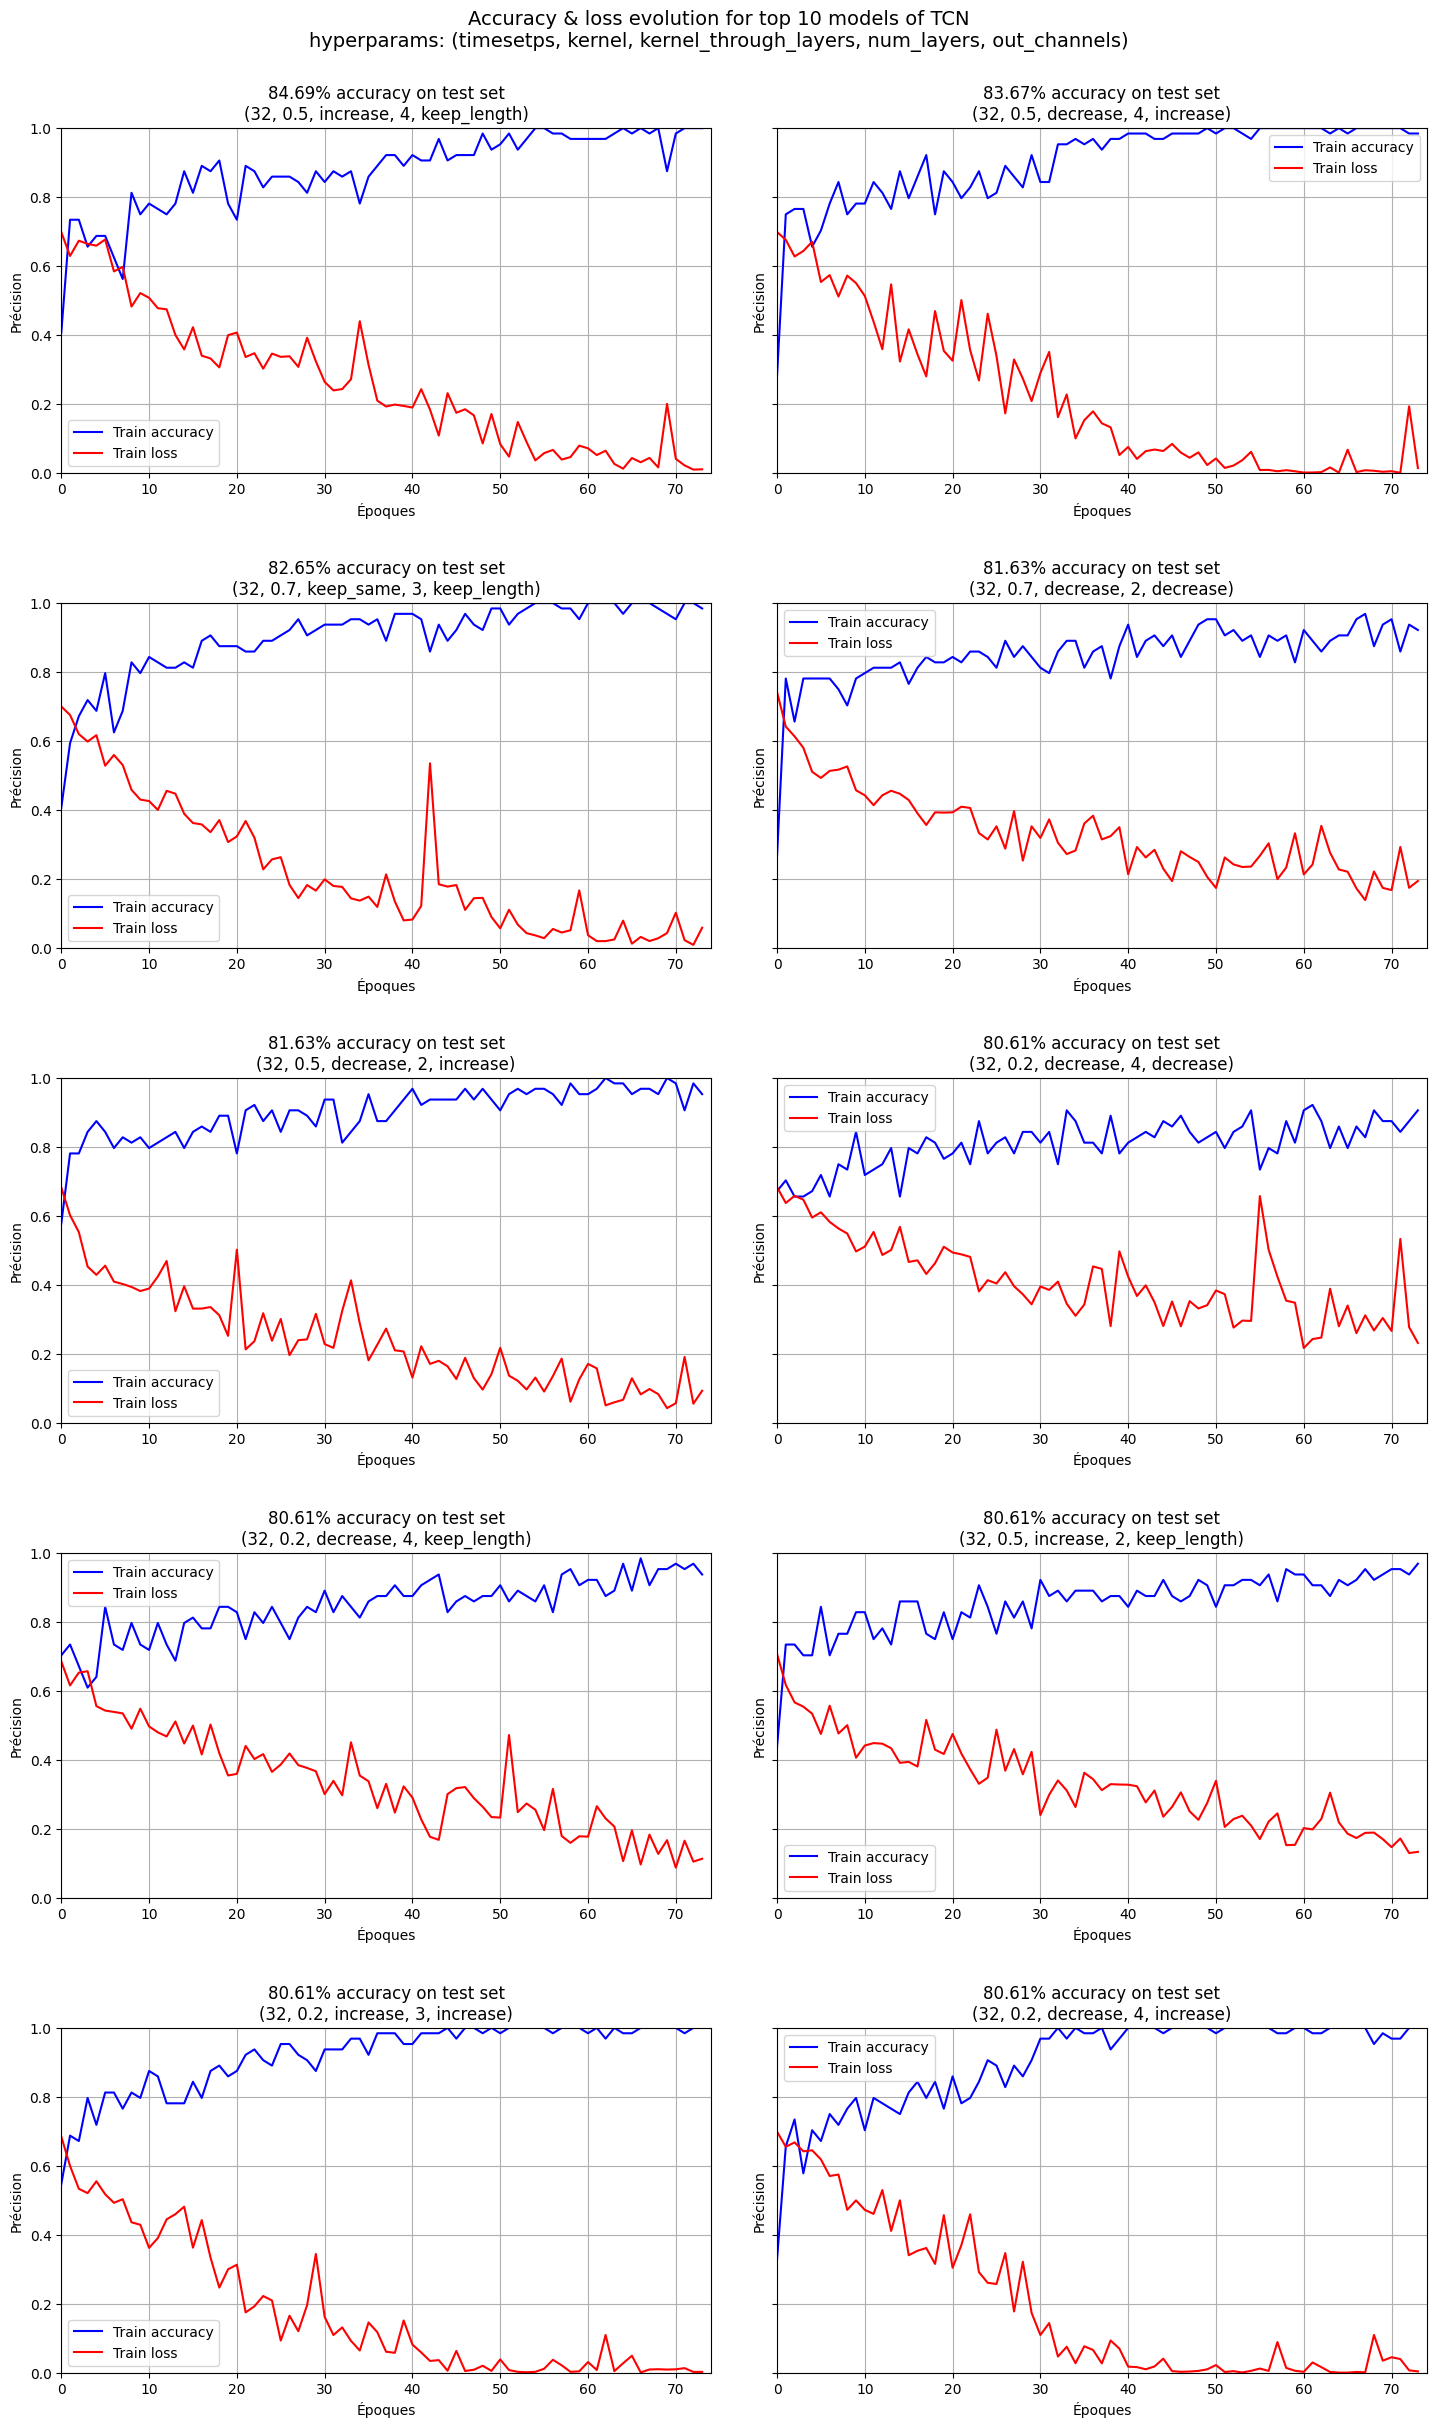

In [69]:
import json

fig, axes = plt.subplots(NB_MODELS // 2, 2, figsize=(15, 25), sharey=True)
axes = axes.flatten()

for index, (_, row) in enumerate(best_models.iterrows()):
    accuracy_train = json.loads(row["accuracy_train"])
    loss_train = json.loads(row["loss_train"])

    ax = axes[index]
    ax.plot(accuracy_train, label="Train accuracy", color='blue')
    ax.plot(loss_train, label="Train loss", color='red')
    # Définir le titre avec précision de test et hyperparamètres
    ax.set_title(
        f"{row['accuracy_test']:.2f}% accuracy on test set\n"
        f"({row['timestep']}, {row['kernel_size']}, "
        f"{row['kernel_size_through_layers']}, {row['num_layers']}, "
        f"{row['out_layers']})"
    )
    
    # Définir les labels des axes
    ax.set_xlabel("Époques")
    ax.set_ylabel("Précision")
    
    # Fixer les mêmes limites pour l'axe Y
    ax.set_ylim(0, 1)
    ax.set_xlim(0, len(accuracy_train))
    
    # Ajouter une légende et une grille
    ax.legend()
    ax.grid(True)

fig.suptitle(f"Accuracy & loss evolution for top {NB_MODELS} models of TCN\nhyperparams: (timesetps, kernel, kernel_through_layers, num_layers, out_channels)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste l'espace pour le suptitle
plt.tight_layout(pad=3.0)
plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

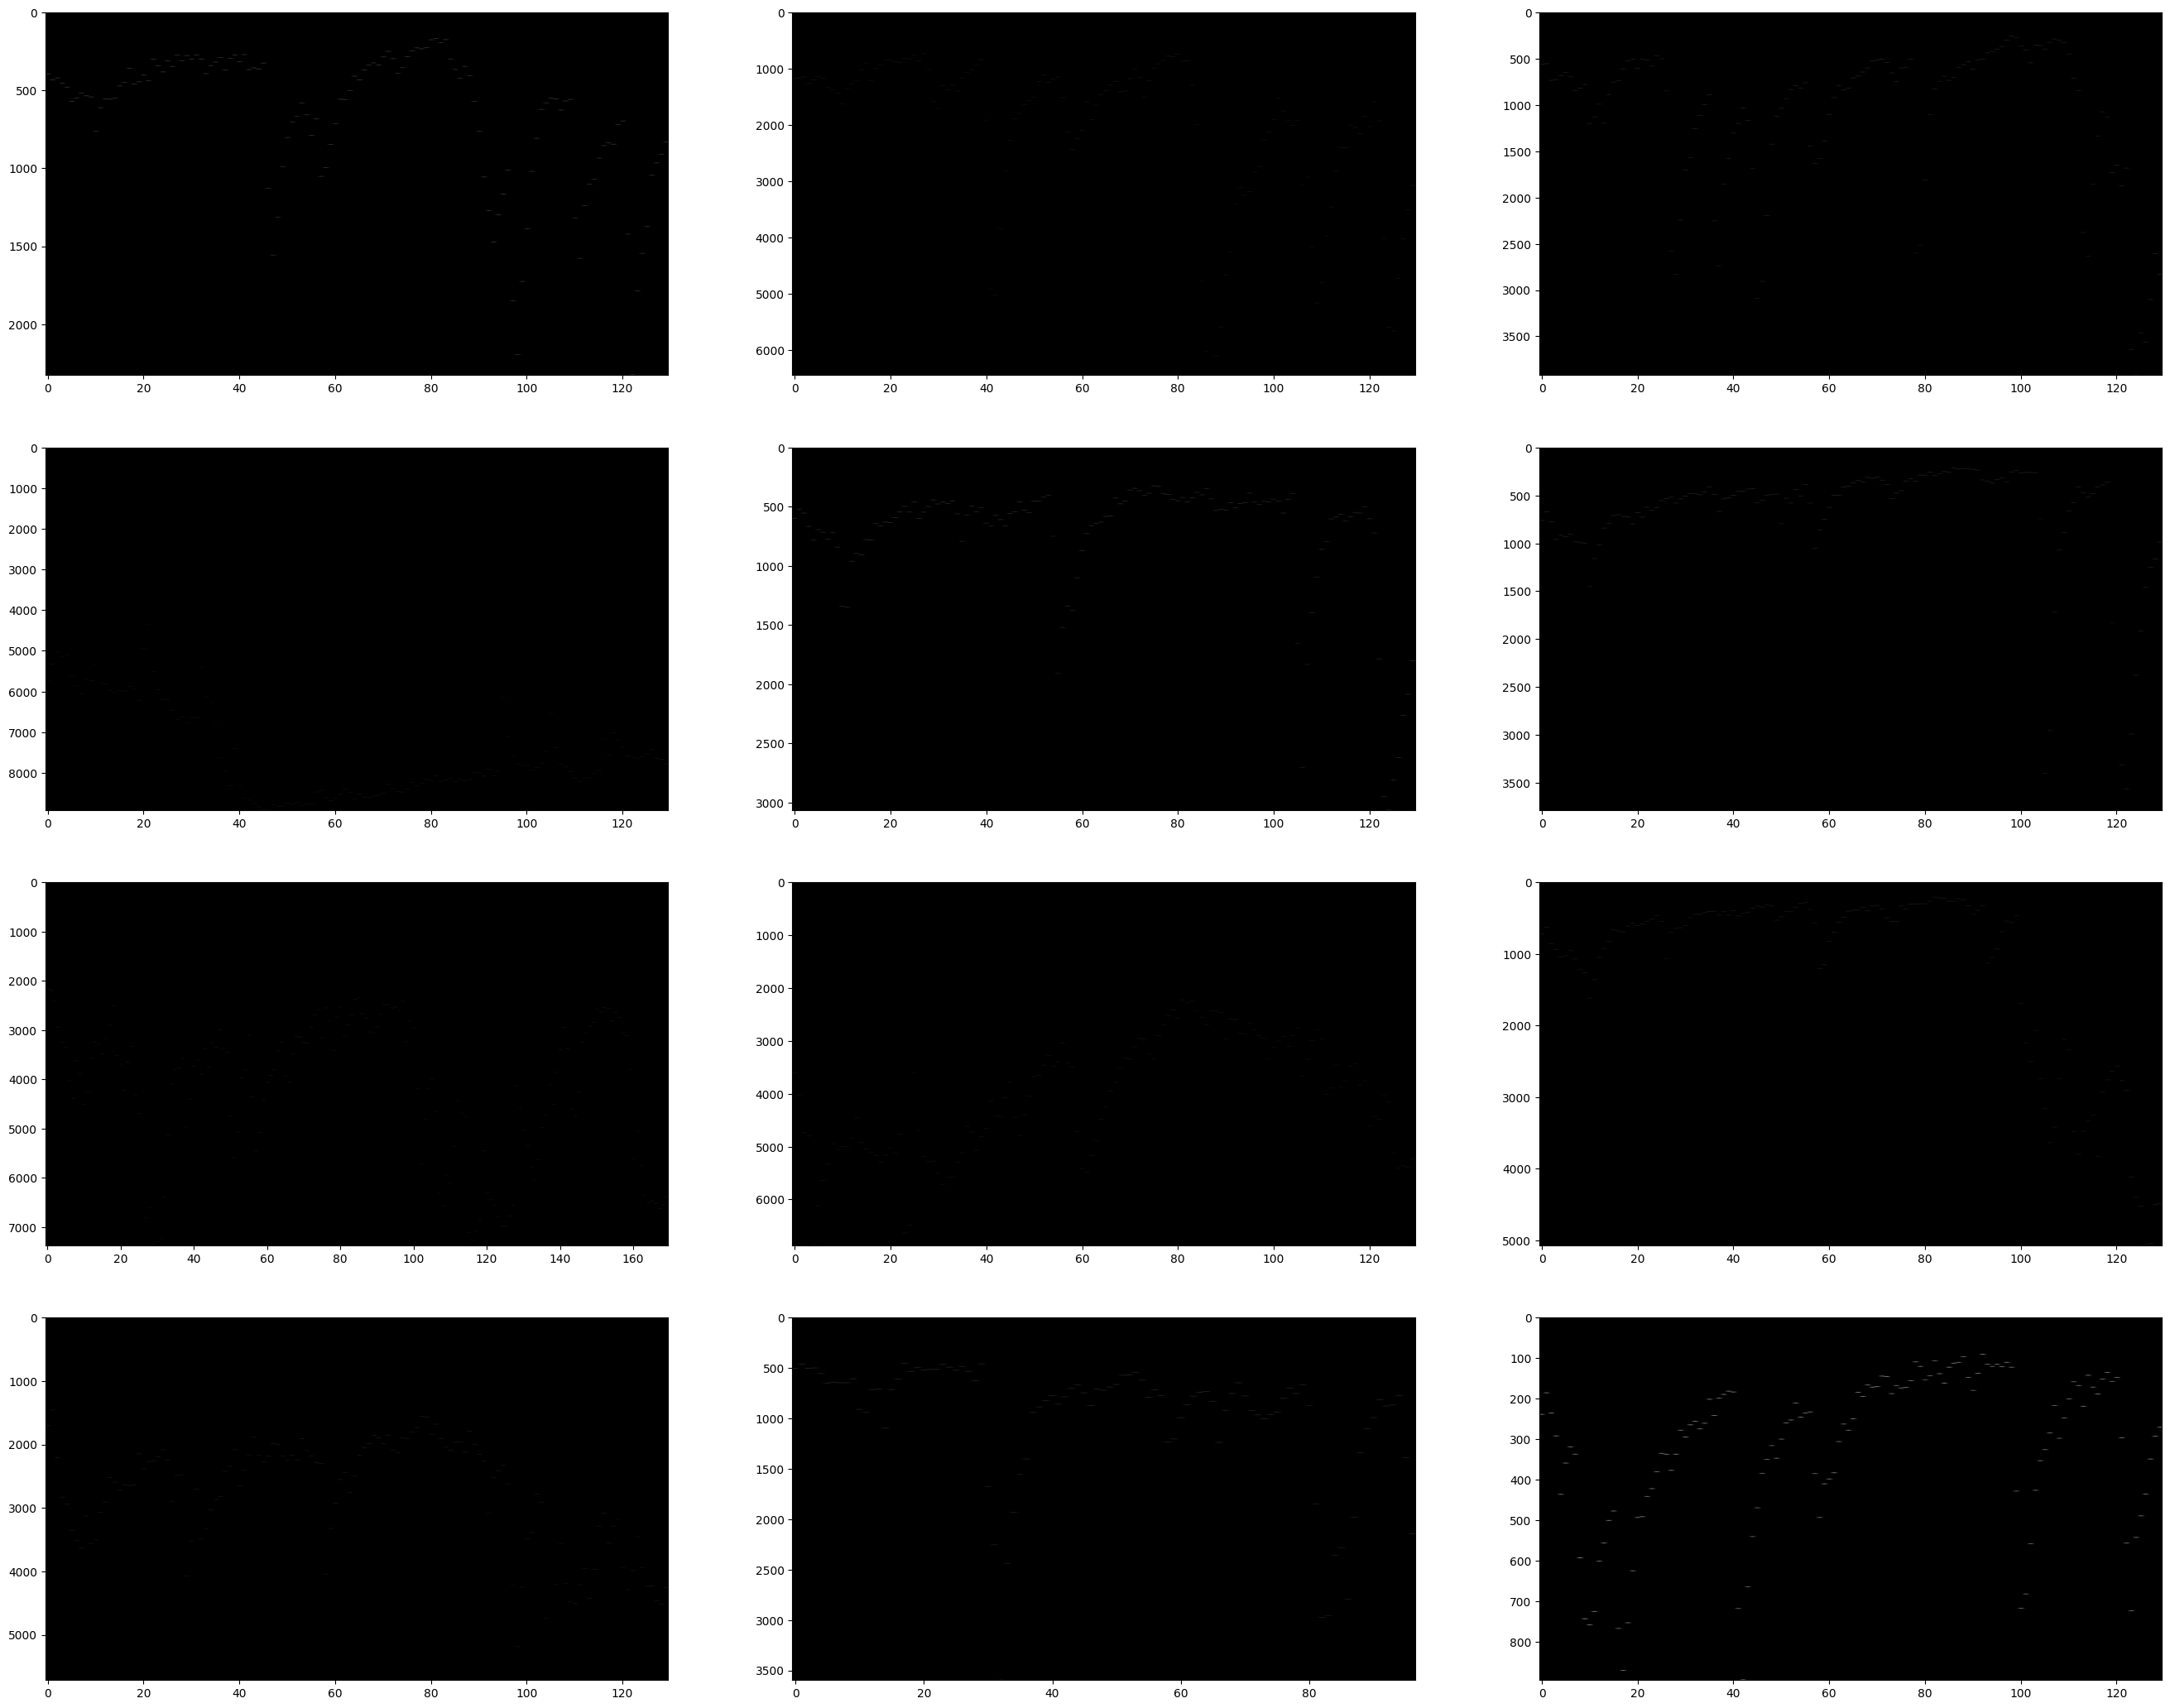

In [ ]:
print("Number of files: ", len(files))

class TCN(nn.Module):
    def __init__(self, input_dim, output_dim, num_channels, kernel_size=3, dropout=0.2):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            in_channels = input_dim if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            dilation = 2 ** i  # Dilation doubles at each level
            padding = (kernel_size - 1) * dilation  # Causal padding

            layers.append(nn.Conv1d(in_channels, out_channels, kernel_size, 
                                    stride=1, padding=padding, dilation=dilation))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        self.tcn = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], output_dim)

    def forward(self, x):
        # Input shape: (batch_size, seq_len, input_dim)
        x = x.permute(0, 2, 1)  # Change to (batch_size, input_dim, seq_len) for Conv1d
        x = self.tcn(x)
        x = x[:, :, -1]  # Take the last output for prediction
        x = self.fc(x)
        return x

Number of files:  17


In [ ]:
# Hyperparameters
input_dim = 1  # 1D input
output_dim = 1  # 1D output
num_channels = [16, 32, 64]  # Number of channels at each layer
kernel_size = 3  # Kernel size for Conv1d
dropout = 0.2

# Initialize the model
model = TCN(input_dim, output_dim, num_channels, kernel_size, dropout).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
n_epochs = 5
for epoch in range(n_epochs):
    for file in train_files:
        # Convert the values to a compatible type
        X_values = X_train[file]["PeriodID"].values.astype(np.float32)
        y_values = y_train[file].values.astype(np.float32)
        
        X = torch.tensor(X_values, dtype=torch.float32).to(device).unsqueeze(-1)
        y = torch.tensor(y_values, dtype=torch.float32).to(device).unsqueeze(-1)

        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item()}")

print("Finished training")
print("Accuracy: ", model.score(X_test, y_test))

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3